In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, solve
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
import time

In [2]:
def load_data(file_name_matrix='tfidf_matrix_97MB.npz', file_name_feature_names='feature_names_97MB.npy',
          file_name_labels='train_labels.npy', samples_in_train_set=10000,
          samples_in_test_set=137562):
    # Recuperation des donnees
    TF_IDF_matrix = sp.load_npz(file_name_matrix)
    TF_IDF_feature_names = np.load(file_name_feature_names)
    train_labels = np.load(file_name_labels, allow_pickle=True)
    train_labels_numeric = ((train_labels == 'Oui') + 0)

    X = TF_IDF_matrix[:samples_in_train_set].toarray()
    y = train_labels_numeric[:samples_in_train_set] * 2 - 1

    X_test = TF_IDF_matrix[samples_in_train_set:samples_in_train_set+samples_in_test_set].toarray()
    y_test = train_labels_numeric[samples_in_train_set:samples_in_train_set+samples_in_test_set] * 2 - 1


    # Standardisation des données
    std_X = np.maximum(np.std(X, axis=0), 1e-7)
    X = X / std_X
    X_test = X_test / std_X

    n = X.shape[0]
    m = X.shape[1]

    n_test = X_test.shape[0]
    
    # Ajout d'une colonne de uns
    eX = np.hstack((np.ones((n,1)), X))
    eX_test = np.hstack((np.ones((n_test,1)), X_test))

    #return X,y,X_test,y_test
    return eX, y, eX_test, y_test


In [3]:
eX,y,eX_test,y_test = load_data()

In [4]:
y.shape

(10000,)

### Question 3.1

We note $x_i \in \mathbb{R}^p$, $w \in \mathbb{R}^p$, $w \in \mathbb{R}$

$f_1 = (w_0,w) \rightarrow \frac{1}{n}\sum_{i=1}^n \log(1 + \exp(-y_i (x_i^\top+w_0))) + \frac{\rho}{2}\|w\|^2 = g(w_0,w) + \frac{\rho}{2}\|w\|^2  = g(w_0,w) + h(w_0,w)$

We can define $\tilde w = [w0,w]^\top$ and $\tilde x_i = [xi^\top,1]^\top$.

So $\nabla g(\tilde w) = \frac{1}{n}\sum_{i=1}^n \frac{-y_i \exp(-y_i \tilde x_i^\top \tilde w ) \tilde x_i}{1 + \exp(-y_i \tilde x_i^\top \tilde w)}$

Since $\frac{d h(w_0,w)}{dw}  = [0, \rho w]^\top$

Therefore, we have the gradient of $f_1$ is 

$$
 \nabla f_1(w_0,w) = \left[
 \begin{matrix}
   \frac{1}{n}\sum_{i=1}^n \frac{-y_i \exp(-y_i (x_iw + w_0) ) (x_iw + w_0)}{1 + \exp(-y_i (x_iw + w_0))}\\
  \frac{1}{n}\sum_{i=1}^n \frac{-y_i \exp(-y_i (x_iw + w_0) ) (x_iw + w_0)}{1 + \exp(-y_i (x_iw + w_0))} x_i + \rho w 
  \end{matrix}
  \right] 
$$

Hessian matrix is
$$
 \left[
 \begin{matrix}
   \frac{df_1}{dw_0^2} &  \frac{df_1}{dw_0 dw} \\ 
  \frac{df_1}{dwdw^0} &  \frac{df_1}{dw^2}
  \end{matrix}
  \right] \tag{3}
$$

$\nabla^2 f_1$ can be written as the sum of $\nabla^2 g(\tilde w)$ and $\nabla^2 h(\tilde w)$, therefore, 


$$\nabla^2 g(\tilde w) = \frac{1}{n}\sum_{i=1}^n\frac{\exp(-y_i \tilde x_i^\top \tilde w)}{\|1 + \exp(-y_i \tilde x_i^\top \tilde w)\|^2 }\tilde x_i \tilde x_i^\top $$

$$
\nabla^2 f_1(w_0,w) = \left[
 \begin{matrix}
\frac{1}{n}\sum_{i=1}^n\frac{\exp(-y_i (x_iw + w_0))}{\|1 + \exp(-y_i (x_iw + w_0))\|^2 } & \frac{1}{n}\sum_{i=1}^n\frac{\exp(-y_i (x_iw + w_0))}{\|1 + \exp(-y_i (x_iw + w_0))\|^2 }x_i\\
\frac{1}{n}\sum_{i=1}^n\frac{\exp(-y_i (x_iw + w_0))}{\|1 + \exp(-y_i (x_iw + w_0))\|^2 }x_i^\top & \frac{1}{n}\sum_{i=1}^n\frac{\exp(-y_i (x_iw + w_0))}{\|1 + \exp(-y_i (x_iw + w_0))\|^2 }x_i x_i^\top + \rho I_p\\
  \end{matrix}
  \right] 
$$




### Question 3.2

In [14]:
def logistic_regression_loss(X,Y,w): #X = tilde x, W = tilde w
    number = X.shape[0]
    #print(X.shape[0],X.shape[1])
    f = 0
    df_w0 = 0
    df_w=0
    df2_00=0
    df2_01=0
    df2_11=0
    df2_10 = 0
    df2 = np.zeros((X.shape[1],X.shape[1]))
    for i in range(number):
        xi = np.expand_dims(X[i][1:],axis = 1)
        f += np.log(1 + np.exp(-Y[i]*(X[i].T@w)))
        df_w0 += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w))
        df_w += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w)) * X[i][1:]
        df2_00 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2
        df2_01 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi
        df2_10 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi.T
        df2_11 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi@xi.T
        
    f = f/number + 1/number/2 * w[1:]@w[1:]
    df_w = df_w + 1/number*w[1:]
    #print(df_w.shape)
    df = np.zeros(X.shape[1]) 
    df[0]= df_w0/number
    df[1:] =np.squeeze(df_w/number)
    
    df2[0,0] = df2_00/number
    df2[0,1:] = np.squeeze(df2_01/number)
    df2[1:,0]=np.squeeze(df2_10/number)
    df2[1:,1:] = df2_11/number
    for i in range(1,X.shape[1]):
        df2[i,i] += 1/number
    return f,df,df2

In [6]:
f,df,df2 = logistic_regression_loss(eX,y,np.zeros(eX.shape[1]))

10000 576


In [7]:
df2

array([[0.25      , 0.05359961, 0.05074763, ..., 0.06745536, 0.14326925,
        0.096354  ],
       [0.05359961, 0.26159167, 0.02377477, ..., 0.01879477, 0.03259928,
        0.02012643],
       [0.05074763, 0.02377477, 0.26040129, ..., 0.01196662, 0.02506709,
        0.02313315],
       ...,
       [0.06745536, 0.01879477, 0.01196662, ..., 0.2683009 , 0.0423312 ,
        0.02748576],
       [0.14326925, 0.03259928, 0.02506709, ..., 0.0423312 , 0.33220431,
        0.06168203],
       [0.096354  , 0.02012643, 0.02313315, ..., 0.02748576, 0.06168203,
        0.28723638]])

### Question 3.3

In [11]:
def newton(eX,y,epsilon,w_init):
    norm_list = []
    i = 0
    w = w_init
    f,df,df2 = logistic_regression_loss(eX,y,w)
    print(np.linalg.norm(df,ord = 2))
    while np.linalg.norm(df,ord = 2) >= epsilon:
        norm = np.linalg.norm(df,ord=2)
        norm_list.append(norm)
        i = i+1
        w = w - np.linalg.inv(df2)@df
        f,df,df2 = logistic_regression_loss(eX,y,w)
        print(norm)
    
    plt.plot(range(i),norm_list)
    plt.show()
    return w,norm_list

10000 576
1.4950280608255968
10000 576
1.4950280608255968
10000 576
0.18968629151309893
10000 576
0.017625025345530846
10000 576
0.00024956619314540847
10000 576
1.2604731896506097e-06
10000 576
1.0816090860218408e-07
10000 576
9.449050075500965e-09
10000 576
8.254731084221495e-10


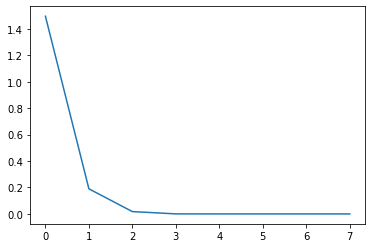

In [12]:
w_init=np.zeros(eX.shape[1])
w = newton(eX,y,10**-10,w_init)

### Question 3.4


10000 576
2.972956600035639
10000 576


<ipython-input-5-700b988d1614>:14: RuntimeWarning: overflow encountered in exp
  f += np.log(1 + np.exp(-Y[i]*(X[i].T@w)))
<ipython-input-5-700b988d1614>:15: RuntimeWarning: overflow encountered in exp
  df_w0 += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w))
<ipython-input-5-700b988d1614>:15: RuntimeWarning: invalid value encountered in double_scalars
  df_w0 += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w))
<ipython-input-5-700b988d1614>:16: RuntimeWarning: overflow encountered in exp
  df_w += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w)) * X[i][1:]
<ipython-input-5-700b988d1614>:16: RuntimeWarning: invalid value encountered in double_scalars
  df_w += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w)) * X[i][1:]
<ipython-input-5-700b988d1614>:17: RuntimeWarning: overflow encountered in exp
  df2_00 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2
<ipython-input-5-700b988d1614>:17: RuntimeWarning: invalid value encountered

2.972956600035639


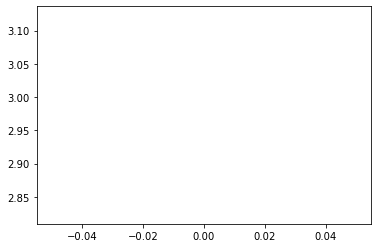

In [13]:
w_init=np.ones(eX.shape[1])
w = newton(eX,y,10**-10,w_init)

### Question 3.5

In [20]:
def armijo_newton(eX,y,epsilon,w,b,a,beta):
    norm_list = []
    i = 0
    f,df,df2 = logistic_regression_loss(eX,y,w)
    print(np.linalg.norm(df,ord = 2))
    while np.linalg.norm(df,ord = 2) >= epsilon:
        norm = np.linalg.norm(df,ord=2)
        norm_list.append(norm)
        i = i+1
        if i > 3:
            w = w - np.linalg.inv(df2)@df
        else:
            l = 0
            w_armijo = w-(b*a)**l*np.linalg.inv(df2)@df
            f_l,df_l,df2_l = logistic_regression_loss(eX,y,w_armijo)
            while f_l - f-beta*np.dot(df,w_armijo - w) >=0:
                l = l + 1
                w_armijo = w-(b*a)**l*np.linalg.inv(df2)@df
                f_l,df_l,df2_l = logistic_regression_loss(eX,y,w_armijo)
            w = w_armijo
        f,df,df2 = logistic_regression_loss(eX,y,w)
        print(norm)
    
    plt.plot(range(i),norm_list)
    plt.show()
    return w,norm_list

1.4950280608255968
1.4950280608255968
0.18968629151309893
0.017625025345530846
0.00887525281238496
6.574845366144883e-05
6.111177267039867e-07
5.322000788423196e-08
4.649428118083012e-09
4.0617421658133096e-10


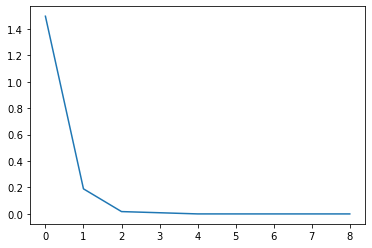

(array([-1.01226061e+00, -1.69898917e-02,  2.39394348e-02, -3.36308257e-02,
         5.50537486e-02,  4.37413643e-02,  3.95275474e-02,  4.41167412e-02,
         4.21717720e-03,  1.20216920e-02,  2.35361524e-02, -9.75848200e-03,
         1.55853171e-02,  3.79376611e-02,  5.92707672e-02, -8.05851894e-03,
         2.90992329e-02,  1.26518473e-02,  4.84172776e-02,  6.01002323e-02,
         4.32291433e-02, -2.62045946e-02, -1.04024659e-02, -5.25258152e-03,
         1.54227822e-02,  1.20649431e-02, -1.92748274e-03,  3.73519839e-02,
         2.33890420e-02,  3.12850072e-02,  1.31088127e-02,  4.47813057e-02,
         5.10199350e-02,  5.24567661e-02,  1.72542928e-02, -9.75637768e-02,
         1.52753672e-02,  1.01577383e-02,  6.52216996e-02,  3.82701100e-02,
        -1.89699340e-02, -5.73612100e-02, -1.07645727e-02,  1.82654917e-02,
         1.28032754e-02,  3.86350614e-02,  6.43104164e-02,  1.74039116e-02,
        -2.62856764e-02, -1.92875970e-03,  3.25491955e-02,  2.60269144e-03,
        -3.4

In [21]:
armijo_newton(eX,y,10**-10,np.zeros(eX.shape[1]),1,0.5,0.5)

We need to choose $a \in (0,1), \beta \in (0,1), b > 0 $ and we set$a=0.5, \beta =0.5, b =1 $

### Question 4.1

We can’t we use Newton’s method to solve this problem because we need f three times continuously differentiable and $L_1$ norm does not satisfy this condition

### Question 4.2

The difference is the second term, the regularization, where we used a $L_1$ normalization. The proximal operator of $L_1$ normalization is easier to calculate, so we note $g_2 = \rho \|\omega\|_1$ and $f_2 = \frac{1}{n}\sum_{i=1}^n \log(1 + \exp(-y_i (x_i^\top+w_0)))$

According to the definition of proximal operator, we have $\text{prox}_g(x) = \text{argmin}_{u} \left(\frac{1}{2}\|u-x\|^2 + g(x)\right)$

So $\text{prox}_{\rho \| \|_1}(\omega) = \text{argmin}_{u} \left(\frac{1}{2}\|u_i-\omega_i\|^2 + \rho \|\omega_i\|_1\right)$, 

and $h(u_i) =\text{prox}_{\rho \| \|_1}(\omega_i) = \text{argmin}_{u_i} \left(\frac{1}{2}\|u_i-\omega_i\|^2 + \rho \|\omega_i\|_1\right)$

We have $\frac{dh(u_i)}{du_i} = u_i-omega_i+\rho$ when $u_i > 0$ and $\frac{dh(u_i)}{du_i} = u_i-omega_i-\rho$ when $u_i < 0$, therefore, $\frac{dh(u_i)}{du_i} = 0 \Leftrightarrow u_i = \omega_i-\rho $ when $u_i > 0$, and  $\frac{dh(u_i)}{du_i} = 0 \Leftrightarrow u_i = \omega_i+\rho $ when $u_i < 0$

When $u_i= 0$, the subgradient of h is $[-1,1]$, and the characteristic of proximal operator shows that $p = \text{prox}_g(\omega) \Leftrightarrow p-\omega\in \partial f(p) $, then in this situation, $0 = \text{prox}_{\rho \|\omega_i\|_1}$.

Therefore, $\text{prox}_{\rho \| \|_1}(\omega_i) = sign(x_i) \times \max(\|\omega_i\| - \rho, 0)$

According to Question 3.1, the gradient of $f_2$ is 

$$
 \nabla f_1(w_0,w) = \left[
 \begin{matrix}
   \frac{1}{n}\sum_{i=1}^n \frac{-y_i \exp(-y_i (x_iw + w_0) ) (x_iw + w_0)}{1 + \exp(-y_i (x_iw + w_0))}\\
  \frac{1}{n}\sum_{i=1}^n \frac{-y_i \exp(-y_i (x_iw + w_0) ) (x_iw + w_0)}{1 + \exp(-y_i (x_iw + w_0))} x_i
  \end{matrix}
  \right] 
$$

### Question 4.3

In [68]:
def logistic_regression_loss2(X,Y,w): #X = tilde x, W = tilde w
    number = X.shape[0]
    #print(X.shape[0],X.shape[1])
    f = 0
    df_w0 = 0
    df_w=0
    df2_00=0
    df2_01=0
    df2_11=0
    df2_10 = 0
    df2 = np.zeros((X.shape[1],X.shape[1]))
    for i in range(number):
        xi = np.expand_dims(X[i][1:],axis = 1)
        f += np.log(1 + np.exp(-Y[i]*(X[i].T@w)))
        df_w0 += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w))
        df_w += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w)) * X[i][1:]
        df2_00 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2
        df2_01 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi
        df2_10 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi.T
        df2_11 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi@xi.T
        
    f = f/number 
    #df_w = df_w + 1/number*w[1:]
    #print(df_w.shape)
    df = np.zeros(X.shape[1]) 
    df[0]= df_w0/number
    df[1:] =np.squeeze(df_w/number)
    
    df2[0,0] = df2_00/number
    df2[0,1:] = np.squeeze(df2_01/number)
    df2[1:,0]=np.squeeze(df2_10/number)
    df2[1:,1:] = df2_11/number
    #for i in range(1,X.shape[1]):
    #   df2[i,i] += 1/number
    return f,df,df2

In [216]:
def taylor_proximal(eX,y,epsilon,w,b,a,rho):
    norm_list = []
    i = 0
    f,df,df2 = logistic_regression_loss2(eX,y,w)
    norm = np.linalg.norm(df,ord=2)
    norm_list.append(norm)
    print(norm)
    while norm >= epsilon:
        i = i+1
        l = 0
        gamma = (b*a)**l
        w_taylor = np.sign(w)*np.maximum(np.absolute(w - gamma*df) - gamma*rho*np.ones(eX.shape[1]),np.zeros(eX.shape[1]))
        f_l,df_l,df2_l = logistic_regression_loss2(eX,y,w_taylor)
        taylor = f_l - f-np.dot(df,w_taylor - w) - 1/2/gamma*np.linalg.norm(w - w_taylor)**2
        while taylor >=0:
            if l < 1: 
                l = l + 1
                print(l)
                gamma = 1
                #gamma = (b*a)**l
                w_taylor = np.sign(w)*np.maximum(np.absolute(w - gamma*df) - gamma*rho*np.ones(eX.shape[1]),np.zeros(eX.shape[1]))
                f_l,df_l,df2_l = logistic_regression_loss2(eX,y,w_taylor)
                taylor = f_l - f-np.dot(df,w_taylor - w) - 1/2/gamma*np.linalg.norm(w - w_taylor)**2 
            else:
                break
        w = w_taylor
        f,df,df2 = logistic_regression_loss2(eX,y,w)
        norm = np.linalg.norm(df,ord=2)
        norm_list.append(norm)
        print(norm)
    
    plt.plot(range(i+1),norm_list)
    plt.show()
    return w

In [217]:
w = taylor_proximal(eX,y,10**-10,np.zeros(eX.shape[1]),10,0.5,0.02)

1.4950280608255968
1
1.4950280608255968
1


KeyboardInterrupt: 

### Question 5

In [7]:
def data_split(X,y,prob):
    if prob < 1 and prob > 0:
        train_len = int(X.shape[0]*prob)
        X_train = X[:train_len]
        y_train = y[:train_len]
        X_valid = X[train_len:]
        y_valid = y[train_len:]
        return X_train,y_train,X_valid,y_valid
    else:
        return X,y,0,0
X_train,y_train,X_valid,y_valid = data_split(eX,y,0.85)

1.472854365255791
0.19115329340066645
0.01852318326033184
0.00027398356085350843
7.211006502742824e-08
7.795626241580256e-15


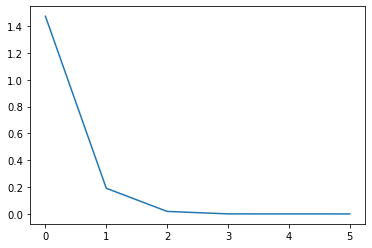

In [138]:
w = taylor_proximal(X_train,y_train,10**-10,np.zeros(eX.shape[1]),1,0.5,0.02)

0.656

In [8]:
def Loss_01 (X_valid,y_valid,w):
    delta = np.sign(np.squeeze(X_valid@np.expand_dims(w,axis = 1))) == y_valid
    delta = delta * np.ones(delta.shape)
    loss = np.sum(delta)/X_valid.shape[0]
    return loss

In [199]:
def find_rho_L1(K,X_train,y_train,X_valid,y_valid):
    rho_0 = 5
    a = 0.5
    K = 5
    k_list = range(K)
    loss_list = []
    for k in k_list:
        rho = rho_0*a**k
        w = taylor_proximal(eX,y,10**-10,np.zeros(eX.shape[1]),1,0.5,rho)
        loss = Loss_01(X_valid,y_valid,w)
        loss_list.append(loss)
    index = np.argmin(loss_list)
    print("best rho = {}".format(rho_0*a**k_list[index]))
    print("loss = {}".format(loss_list))
    plt.plot(k_list,loss_list)
    plt.show()
    return rho_0*a**k_list[index]

1.4950280608255968
0.1897413568153114
0.0176250984303564
0.00024453236197755903
5.680792121357792e-08
5.194710276812563e-15


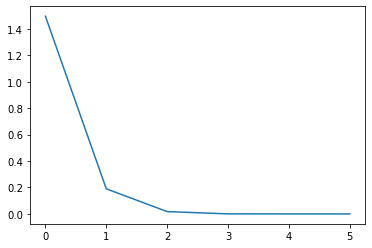

1.4950280608255968
0.1897413568153114
0.0176250984303564
0.00024453236197755903
5.680792121357792e-08
5.194710276812563e-15


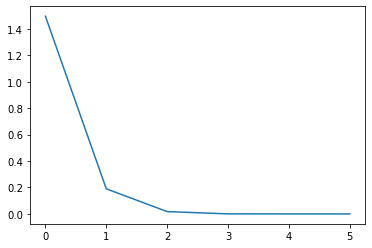

1.4950280608255968
0.1897413568153114
0.0176250984303564
0.00024453236197755903
5.680792121357792e-08
5.194710276812563e-15


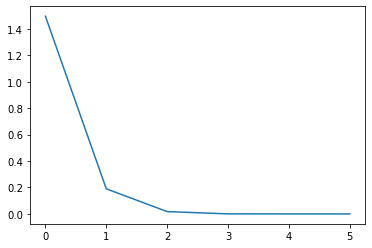

1.4950280608255968
0.1897413568153114
0.0176250984303564
0.00024453236197755903
5.680792121357792e-08
5.194710276812563e-15


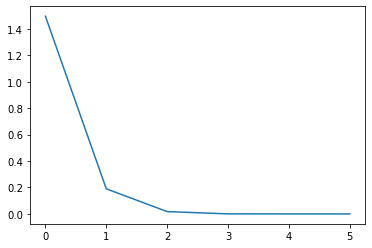

1.4950280608255968
0.1897413568153114
0.0176250984303564
0.00024453236197755903
5.680792121357792e-08
5.194710276812563e-15


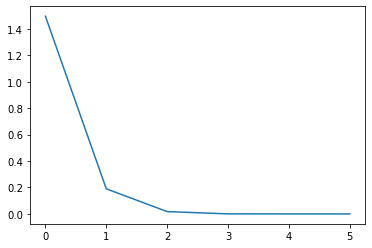

best rho = 5.0
loss = [0.718, 0.718, 0.718, 0.718, 0.718]


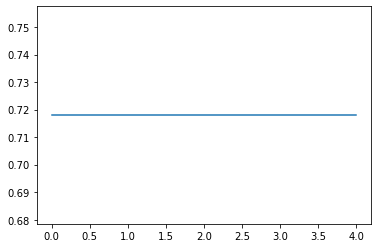

In [200]:
rho_L1 = find_rho_L1(5,X_train,y_train,X_valid,y_valid)

In [5]:
def logistic_regression_loss_L2(X,Y,w,rho): #X = tilde x, W = tilde w
    number = X.shape[0]
    #print(X.shape[0],X.shape[1])
    f = 0
    df_w0 = 0
    df_w=0
    df2_00=0
    df2_01=0
    df2_11=0
    df2_10 = 0
    df2 = np.zeros((X.shape[1],X.shape[1]))
    for i in range(number):
        xi = np.expand_dims(X[i][1:],axis = 1)
        f += np.log(1 + np.exp(-Y[i]*(X[i].T@w)))
        df_w0 += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w))
        df_w += -Y[i]*np.exp(-Y[i]*X[i].T@w) / (1 + np.exp(-Y[i]*X[i].T@w)) * X[i][1:]
        df2_00 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2
        df2_01 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi
        df2_10 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi.T
        df2_11 += np.exp(-Y[i]*X[i].T@w) / abs(1+np.exp(-Y[i]*X[i].T@w))**2 * xi@xi.T
        
    f = f/number + rho/2 * w[1:]@w[1:]
    df_w = df_w + rho*w[1:]
    #print(df_w.shape)
    df = np.zeros(X.shape[1]) 
    df[0]= df_w0/number
    df[1:] =np.squeeze(df_w/number)
    
    df2[0,0] = df2_00/number
    df2[0,1:] = np.squeeze(df2_01/number)
    df2[1:,0]=np.squeeze(df2_10/number)
    df2[1:,1:] = df2_11/number
    for i in range(1,X.shape[1]):
        df2[i,i] += rho
    return f,df,df2


def newton_L2(eX,y,epsilon,w_init,rho):
    norm_list = []
    i = 0
    w = w_init
    f,df,df2 = logistic_regression_loss_L2(eX,y,w,rho)
    #print(np.linalg.norm(df,ord = 2))
    while np.linalg.norm(df,ord = 2) >= epsilon:
        norm = np.linalg.norm(df,ord=2)
        norm_list.append(norm)
        i = i+1
        w = w - np.linalg.inv(df2)@df
        f,df,df2 = logistic_regression_loss_L2(eX,y,w,rho)
        #print(norm)
    
    #plt.plot(range(i),norm_list)
    #plt.show()
    return w,norm_list

def find_rho_L2(K,X_train,y_train,X_valid,y_valid):
    rho_0 = 5
    a = 0.5
    K = 5
    k_list = range(K)
    loss_list = []
    for k in k_list:
        rho = rho_0*a**k
        w =  newton_L2(eX,y,10**-10,np.zeros(eX.shape[1]),rho)
        loss = Loss_01(X_valid,y_valid,w)
        loss_list.append(loss)
    index = np.argmin(loss_list)
    print("best rho = {}".format(rho_0*a**k_list[index]))
    print("loss = {}".format(loss_list))
    plt.plot(k_list,loss_list)
    plt.show()
    return rho_0*a**k_list[index]

In [9]:
find_rho_L2(5,X_train,y_train,X_valid,y_valid)

KeyboardInterrupt: 

### Question 6.1

The difference of the two optimization problems is the regularization term, where method 1 utilise $L_2$ norm and method 2 utilise $L_1$ norm. 

$L_1$ regularization causes the parameter value to become 0, but $L_2$ only decreases the value of parameters.

### Question 6.2

In [14]:
def confusion_matrix (X_valid, y_valid, w):
    TP=0
    FP=0
    FN=0
    TN=0
    for i in range(X_valid.shape[0]):
        if np.sign(X_valid[i]@w) == y_valid[i]:
            if y_valid[i] == 1:
                TP = TP+1
            else:
                TN = TN+1
        else:
            if y_valid[i] == 1:
                FP = TP+1
            else:
                FN = TN+1
    confusion_matrix = np.zeros((2,2))
    confusion_matrix[0,0] = TP
    confusion_matrix[0,1] = FP
    confusion_matrix[1,0] = FN
    confusion_matrix[1,1] = TN
    return confusion_matrix